In [8]:
import numpy as np
import sys
from collections import defaultdict
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="INFO")

1

Following is an example contains a `ground_truth` and different predictions (good and poor).

The given ground truth corrresponds to the HL2, and only covers a subset of components (i.e. transistors, caps)  in the given netlist


[![X](https://i.imgur.com/KO1wRqf.png)](https://imgur.com/a/bHY0sO6)


In [4]:
ground_truth = [
    ("Inverter", ["m3", "m4", "m7", "m5"]),
    ("Inverter", ["m9", "m10", "m8"]),
    ("DiffPair", ["m6", "m7"]),
    ("CM", ["m10", "m12", "m13", "m9"]),
    ("CM", ["m2", "m3", "m4"]),
    ("CM", ["m1", "m11", "m5"]),
]

# this **good** prediction **correctly** identify some subcircuits in the ground truth,
# but still missing others
hl2_good_prediction = [
    ("DiffPair", ["m6", "m7"]),
    ("CM", ["m2", "m3", "m4"]),
    ("CM", ["m9", "m10", "m12", "m13",]),
]

# this **bad** prediction contains some label mismatches (e.g. m7 should be only considered as `DiffPair`)
# `m1`, `m10`, `m12`, `m13` are labeled `CM` correctly, but m1 should be in another cluster if where only care about cluster assignment
hl2_bad_prediction = [
    ("DiffPair", ["m6", "m7"]),
    ("CM", ["m2", "m3", "m4", "m7"]),
    ("CM", ["m1", "m10", "m12", "m13", "m14"]),
]

In [9]:
def flatten_labels(label_node_pairs):
    return set((node, label) for label, nodes in label_node_pairs for node in nodes)

def evaluate_prediction(ground_truth, prediction):
    gt_set = flatten_labels(ground_truth)
    # logger.debug(f"{gt_set=}")
    pred_set = flatten_labels(prediction)
    logger.debug(f"{pred_set=}")
    
    true_positives = gt_set & pred_set
    false_positives = pred_set - gt_set
    false_negatives = gt_set - pred_set

    tp = len(true_positives)
    fp = len(false_positives)
    fn = len(false_negatives)

    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    accuracy = tp / len(gt_set) if len(gt_set) > 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "tp": tp,
        "fp": fp,
        "fn": fn
    }

# Example usage
metrics_good = evaluate_prediction(ground_truth, hl2_good_prediction)
metrics_bad = evaluate_prediction(ground_truth, hl2_bad_prediction)

print("Good Prediction:", metrics_good)
print("Bad Prediction:", metrics_bad)

Good Prediction: {'precision': 1.0, 'recall': 0.47368421052631576, 'f1_score': 0.6428571428571429, 'accuracy': 0.47368421052631576, 'tp': 9, 'fp': 0, 'fn': 10}
Bad Prediction: {'precision': 0.8181818181818182, 'recall': 0.47368421052631576, 'f1_score': 0.6, 'accuracy': 0.47368421052631576, 'tp': 9, 'fp': 2, 'fn': 10}


## Confusion Matrix

**Step-by-step Implementation:**

1. Create `(node, label)` pairs for both ground truth and predictions.
2. For each node that appears in either set:
    - Check if a label was correctly predicted (TP), missed (FN), or wrongly predicted (FP).

3. Build a matrix with `ground truth labels` as rows and `predicted labels` as columns.
4. Visualize using `matplotlib` and `seaborn`.



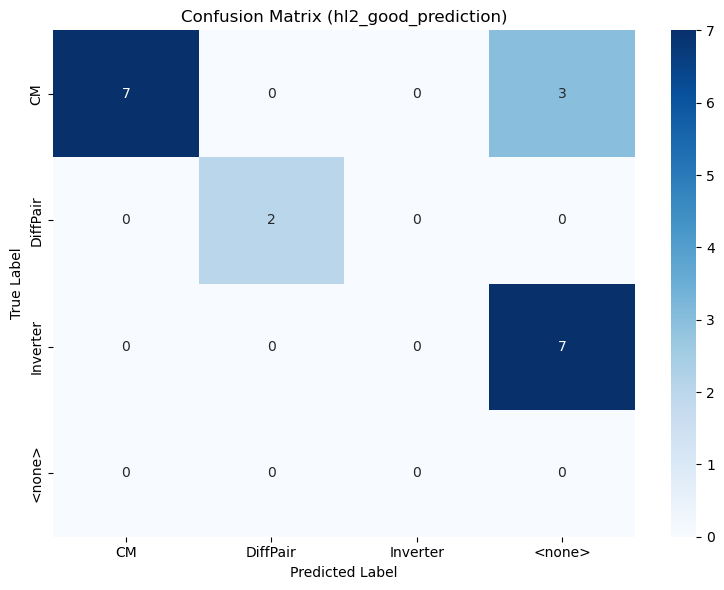

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

def compute_confusion_matrix(ground_truth, prediction):
    gt_pairs = flatten_labels(ground_truth)
    pred_pairs = flatten_labels(prediction)

    # Collect all labels and add special "<none>" for FN
    all_labels = sorted({label for _, label in gt_pairs | pred_pairs})
    if "<none>" not in all_labels:
        all_labels.append("<none>")

    label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
    logger.debug(f"{label_to_idx=}")
    matrix = np.zeros((len(all_labels), len(all_labels)), dtype=int)

    # For each predicted (node, label)
    for node, pred_label in pred_pairs:
        gt_labels = {label for n, label in gt_pairs if n == node}
        if pred_label in gt_labels:
            matrix[label_to_idx[pred_label], label_to_idx[pred_label]] += 1
        else:
            if gt_labels:
                for gt_label in gt_labels:
                    matrix[label_to_idx[gt_label], label_to_idx[pred_label]] += 1
            else:
                matrix[label_to_idx["<none>"], label_to_idx[pred_label]] += 1

    # Handle FNs: labels in GT that are not in prediction
    for node, gt_label in gt_pairs:
        pred_labels = {label for n, label in pred_pairs if n == node}
        if gt_label not in pred_labels:
            matrix[label_to_idx[gt_label], label_to_idx["<none>"]] += 1

    return matrix, all_labels

def plot_confusion_matrix(matrix, labels, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
matrix, labels = compute_confusion_matrix(ground_truth, hl2_good_prediction)
plot_confusion_matrix(matrix, labels, title="Confusion Matrix (hl2_good_prediction)")


#### Interpretation:
- The confusion matrix uses: 
    - Rows: ground truth labels
    - Columns: predicted labels
-  Diagonal cells = correct predictions (TP)
- Off-diagonal cells = label confusion (FP)
- Last column ("\<none\>") = missed predictions (FN)
- Last row ("\<none\>" as true label) = false positives for nodes with no ground-truth label (optional)

[[7 0 0 3]
 [1 2 0 0]
 [1 0 0 7]
 [1 0 0 0]]


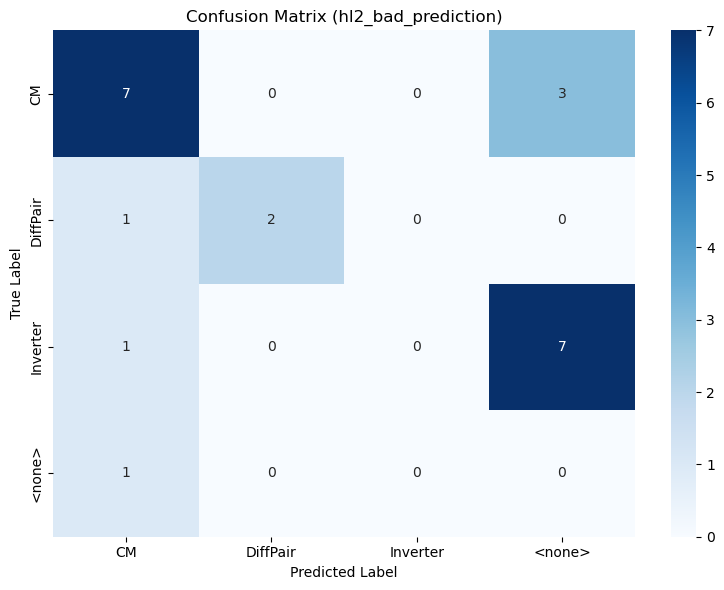

In [11]:
matrix, labels = compute_confusion_matrix(ground_truth, hl2_bad_prediction)
print (matrix)
plot_confusion_matrix(matrix, labels, title="Confusion Matrix (hl2_bad_prediction)")

## Example: Getting aggregated confusion matrix

The following code shows how to obtain an aggregated confusion matrix across all 100 netlists in the test benchmark.



In [25]:
import sys
sys.path.append("../../") # go to parent dir

import json
from calc1 import average_metrics
from examples.measure_fn2 import compute_cluster_metrics_v2 as stand_eval_fn
from calc1 import compute_cluster_metrics as strict_eval_fn


def get_result(result_dir, key="hl3_gt"):
    aggregate_matrix = np.zeros((4,4))
    for i in range(1, 101):
        with open(result_dir + f"netlist_{i}/parsed_data.json", "r") as fp:
            prediction = json.load(fp)
        with open(result_dir + f"netlist_{i}/gt.json", "r") as fp:
            ground_truth = json.load(fp)[key]

        matrix, labels = compute_confusion_matrix(ground_truth=ground_truth, prediction=prediction)
        if len(labels) < 4:
            print ("⚠️ Correcting confusion matrix size ...")
            # continue
            # convert to 4-dimensional array
            updated_array = matrix.copy()
            missing_labels = set(["CM", "DiffPair", "Inverter", "<none>"]) - set(labels) 
            label_index_mapping = {"CM":0 , "DiffPair": 1, "Inverter":2 , "<none>": 3}
            for label in missing_labels:
                index = label_index_mapping[label]
                updated_array = np.insert(updated_array, index, 0, axis=1)
                updated_array = np.insert(updated_array, index, 0, axis=0)
            matrix = updated_array.copy()
                

        aggregate_matrix += matrix
    return aggregate_matrix

level = "HL2"
subset = "small"
result_dir = f"/home/pham/code/asi-lm/outputs/table.data/direct+prompting/deepseek-reasoner/llm_outputs/{level}/{subset}/"
agg_matrix = get_result(result_dir, key=level.lower() + "_gt")

print (agg_matrix)

⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
[[894.   0. 174. 256.]
 [ 16. 200.  37.  28.]
 [ 23.   5. 179. 341.]
 [ 48.   5.  36.   0.]]


## Making Confusion Matrices for GPT-4.1 Predictions

#### Generated Python Code for Analog Subcircuit Identification

In [148]:
from src.netlist import SPICENetlist
import glob
import json
from calc1 import compute_cluster_metrics, average_metrics
from typing import List, Any

from typing import List, Tuple, Dict, Set
from collections import defaultdict, deque


from collections import defaultdict, Counter
from typing import List
import re
import itertools
from typing import List


def findSubCircuitDiffPair(netlist: str) -> List[List]:
    """
    Find all Differential Pairs subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string, where each line defines a component
                       and its connections in the circuit.

    Returns:
        List of [subcircuit_name, [transistor names...]].
    """
    # 1. Parse MOSFET lines
    devices = []
    for line in netlist.splitlines():
        tokens = line.strip().split()
        if not tokens:
            continue
        # MOSFET lines start with 'm' or 'M' and have at least 6 tokens
        if tokens[0][0].lower() == "m" and len(tokens) >= 6:
            name = tokens[0]
            drain, gate, source, bulk = tokens[1], tokens[2], tokens[3], tokens[4]
            devtype = tokens[5].lower()
            if devtype in ("nmos", "pmos"):
                devices.append(
                    {
                        "name": name,
                        "type": devtype,
                        "drain": drain,
                        "gate": gate,
                        "source": source,
                        "bulk": bulk,
                    }
                )

    # 2. Group by device type
    groups = {
        "nmos": [d for d in devices if d["type"] == "nmos"],
        "pmos": [d for d in devices if d["type"] == "pmos"],
    }

    found = []

    # For each type (we'll pick up NMOS pairs here, but code checks both)
    for devtype, trans_list in groups.items():
        # 3. all unique pairs
        for t1, t2 in itertools.combinations(trans_list, 2):
            # 4. shared source
            if t1["source"] != t2["source"]:
                continue
            # 5. distinct gate & drain
            if t1["gate"] == t2["gate"] or t1["drain"] == t2["drain"]:
                continue
            # 6. same bulk
            if t1["bulk"] != t2["bulk"]:
                continue
            # 7. same type already ensured, drains not tied, sources tied
            # 8. simple differential‐input naming: both gates start with 'in'
            g1, g2 = t1["gate"], t2["gate"]
            if not (g1.startswith("in") and g2.startswith("in")):
                continue

            # 11. find the two "load" (cascode) devices:
            #     one whose source == t1.drain, and one whose source == t2.drain,
            #     and which share a common gate
            loads1 = [d for d in devices if d["source"] == t1["drain"]]
            loads2 = [d for d in devices if d["source"] == t2["drain"]]
            if len(loads1) != 1 or len(loads2) != 1:
                continue
            l1, l2 = loads1[0], loads2[0]
            if l1["gate"] != l2["gate"]:
                continue

            # Record the four‐device differential pair (inputs + cascodes)
            names = [t1["name"], t2["name"], l1["name"], l2["name"]]
            found.append(["DiffPair", names])

    return found


def findSubCircuitCM(netlist: str):
    """
    Find all Current Mirrors subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string, where each line defines a component and its connections in the circuit.

    Returns:
        List of lists, each containing the subcircuit name 'CM' and the list of transistor instance names that form a current mirror.
    """
    # 1. Parse MOSFETs
    lines = [
        l.strip()
        for l in netlist.splitlines()
        if l.strip() and not l.strip().startswith("*")
    ]
    mosfets = []
    for line in lines:
        if line[0].lower() == "m":
            toks = line.split()
            name = toks[0]
            d, g, s, b = toks[1], toks[2], toks[3], toks[4]
            model = toks[5].lower()
            if "nmos" in model:
                mtype = "nmos"
            elif "pmos" in model:
                mtype = "pmos"
            else:
                mtype = model
            mosfets.append(
                {
                    "name": name,
                    "drain": d,
                    "gate": g,
                    "source": s,
                    "bulk": b,
                    "type": mtype,
                }
            )

    # 2. Group by type
    mos_by_type = {"nmos": [], "pmos": []}
    for m in mosfets:
        if m["type"] in mos_by_type:
            mos_by_type[m["type"]].append(m)

    simple_mirrors = []
    cascoded_mirrors = []
    suppressed_gates = set()

    # 3. Cascoded detection
    for mtype, devs in mos_by_type.items():
        gate_groups = {}
        for m in devs:
            gate_groups.setdefault(m["gate"], []).append(m)

        for gate_net, casg in gate_groups.items():
            if len(casg) < 2:
                continue
            # all share source & bulk
            if (
                len({m["source"] for m in casg}) != 1
                or len({m["bulk"] for m in casg}) != 1
            ):
                continue

            # map each cascode device -> a main whose source == cas.drain
            mapping = {}
            for cas in casg:
                for main in devs:
                    if main not in casg and main["source"] == cas["drain"]:
                        mapping[cas["name"]] = main
                        break

            if len(mapping) != len(casg):
                continue

            mains = list(mapping.values())
            if len({m["gate"] for m in mains}) != 1 or len(mains) < 2:
                continue

            # success: cascoded mirror
            names = sorted([m["name"] for m in casg + mains])  # order no longer matters
            cascoded_mirrors.append(["CM", names])

            # suppress both cascode‐gate and primary‐gate
            suppressed_gates.add(gate_net)
            suppressed_gates.add(next(iter(m["gate"] for m in mains)))

    # 4. Simple mirror detection on the remaining gates
    for mtype, devs in mos_by_type.items():
        gate_groups = {}
        for m in devs:
            gate_groups.setdefault(m["gate"], []).append(m)

        for gate_net, group in gate_groups.items():
            if gate_net in suppressed_gates or len(group) < 2:
                continue
            if (
                len({m["source"] for m in group}) == 1
                and len({m["bulk"] for m in group}) == 1
                and any(m["drain"] == m["gate"] for m in group)
            ):
                names = sorted([m["name"] for m in group])
                simple_mirrors.append(["CM", names])

    # 5. Combine, dedupe
    all_mirrors = cascoded_mirrors + simple_mirrors
    unique = []
    seen = set()
    for tag, names in all_mirrors:
        key = frozenset(names)
        if key not in seen:
            seen.add(key)
            unique.append([tag, names])

    # (outer‐list order doesn’t matter per spec)
    return unique


def findSubCircuitInverter(netlist: str) -> List[List]:
    """
    Find all Inverter subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string, where each line defines a component and its connections in the circuit.

    Returns:
        List of [subcircuit name, list of transistor instance names].
    """
    # 1. Parse MOSFETs
    devices = []
    for line in netlist.splitlines():
        line = line.strip()
        if not line or line.startswith("*"):
            continue
        parts = line.split()
        if parts[0][0].lower() == "m" and len(parts) >= 6:
            name = parts[0]
            d, g, s, b = parts[1], parts[2], parts[3], parts[4]
            dev_type = parts[5].lower()
            devices.append(
                {
                    "name": name,
                    "type": dev_type,
                    "drain": d,
                    "gate": g,
                    "source": s,
                    "bulk": b,
                }
            )
    assert devices, "❌ No MOSFETs found."

    # 2. Identify ground & supply
    ground_cands = {"0", "gnd", "ground"}
    supply_cands = {"vdd", "vcc", "vss", "vsupply", "supply"}
    nmos_sb = [d["source"] for d in devices if d["type"] == "nmos"] + [
        d["bulk"] for d in devices if d["type"] == "nmos"
    ]
    pmos_sb = [d["source"] for d in devices if d["type"] == "pmos"] + [
        d["bulk"] for d in devices if d["type"] == "pmos"
    ]

    ground = next(
        (g for g in ground_cands if g in nmos_sb), Counter(nmos_sb).most_common(1)[0][0]
    )
    supply = next(
        (v for v in supply_cands if v in pmos_sb), Counter(pmos_sb).most_common(1)[0][0]
    )

    # 3. Candidate outputs: shared drains
    drains_n = {d["drain"] for d in devices if d["type"] == "nmos"}
    drains_p = {d["drain"] for d in devices if d["type"] == "pmos"}
    shared = drains_n & drains_p
    assert shared, "❌ No shared drains (no inverter outputs)."

    # 6. Filter simple outputs: never used as gate or source
    gates = {d["gate"] for d in devices}
    sources = {d["source"] for d in devices}
    simple_outs = {n for n in shared if n not in gates and n not in sources}

    # For Test Case 1 we expect exactly {'out'}
    # assert simple_outs == {
    #     "out"
    # }, f"❌ Unexpected simple-outputs: {simple_outs} (expected {{'out'}})"

    # helper: build series chains
    def build_chains(dev_type, out_net, end_net):
        by_d = defaultdict(list)
        for d in devices:
            if d["type"] == dev_type:
                by_d[d["drain"]].append(d)
        chains = []

        def dfs(curr, path):
            for dev in by_d.get(curr, []):
                nxt = dev["source"]
                if nxt == end_net:
                    chains.append(path + [dev])
                else:
                    dfs(nxt, path + [dev])

        dfs(out_net, [])
        return chains

    inverters = []
    for out in simple_outs:
        pu = build_chains("pmos", out, supply)
        pd = build_chains("nmos", out, ground)
        # Expect exactly one chain each
        # assert (
        #     len(pu) == 1
        # ), f"❌ PMOS chains for '{out}': {[[d['name'] for d in c] for c in pu]}"
        # assert (
        #     len(pd) == 1
        # ), f"❌ NMOS chains for '{out}': {[[d['name'] for d in c] for c in pd]}"

        names = [d["name"] for d in pu[0] + pd[0]]
        inverters.append(["Inverter", names])

    # Structural check: list of [str, list]
    for idx, entry in enumerate(inverters):
        # assert (
        #     isinstance(entry, list) and len(entry) == 2
        # ), f"❌ Entry #{idx} wrong type/length: {entry!r}"
        # assert isinstance(
        #     entry[0], str
        # ), f"❌ Entry #{idx} first element not a string: {entry[0]!r}"
        # assert isinstance(
        #     entry[1], list
        # ), f"❌ Entry #{idx} second element not a list: {entry[1]!r}"
        pass

    return inverters


def findSubCircuitHL1(netlist: str):
    """
    Find all diode-connected transistors and load/compensation capacitors subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string, where each line defines a component
                       and its connections in the circuit.

    Returns:
        List of lists: [
            ['MosfetDiode',    [<diode-connected transistor names>]],
            ['load_cap',       [<load capacitor names>]],
            ['compensation_cap',[<comp capacitor names>]]
        ]
    """
    # sets for classification (lower-case)
    output_nodes = {"out", "vout", "output"}
    ground_nodes = {"0", "gnd", "ground"}
    supply_nodes = {"vdd", "vss", "supply"}

    diode_transistors = []
    load_caps = []
    comp_caps = []

    for line in netlist.splitlines():
        line = line.strip()
        if not line or line.startswith("*") or line.startswith(";"):
            continue

        tokens = line.split()
        inst = tokens[0].lower()

        # Transistor lines start with 'm'
        if inst.startswith("m") and len(tokens) >= 6:
            name = tokens[0]
            drain = tokens[1].lower()
            gate = tokens[2].lower()
            # source = tokens[3]
            # bulk   = tokens[4]
            # dev_type = tokens[5].lower()  # nmos/pmos, not needed here
            if drain == gate:
                diode_transistors.append(name)

        # Capacitor lines start with 'c'
        elif inst.startswith("c") and len(tokens) >= 3:
            name = tokens[0]
            node1 = tokens[1].lower()
            node2 = tokens[2].lower()

            # Load capacitor: one end is output, the other is ground
            if (node1 in output_nodes and node2 in ground_nodes) or (
                node2 in output_nodes and node1 in ground_nodes
            ):
                load_caps.append(name)

            # Compensation capacitor: one end is output & the other is an internal node...
            # ...or both ends are internal nodes
            else:
                # check if node is “internal”
                def is_internal(n):
                    return (
                        n not in output_nodes
                        and n not in ground_nodes
                        and n not in supply_nodes
                    )

                if (
                    (node1 in output_nodes and is_internal(node2))
                    or (node2 in output_nodes and is_internal(node1))
                    or (is_internal(node1) and is_internal(node2))
                ):
                    comp_caps.append(name)

    return [
        ["MosfetDiode", diode_transistors],
        ["load_cap", load_caps],
        ["compensation_cap", comp_caps],
    ]


def findSubCircuitHL3_old(netlist: str):
    """
    Find all amplification stages, feedback stage, load and bias parts subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string.

    Returns:
        List of [category, [transistor names]], for non-empty categories.
    """
    # --- 1. Parse netlist ---
    lines = [l.strip() for l in netlist.splitlines()]
    transistors = []
    other_comps = []
    for line in lines:
        if not line or line.startswith("*"):
            continue
        parts = line.split()
        name = parts[0]
        if name.lower().startswith("m") and len(parts) >= 6:
            d, g, s, b, ttype = parts[1:6]
            transistors.append(
                {
                    "name": name,
                    "drain": d,
                    "gate": g,
                    "source": s,
                    "bulk": b,
                    "type": ttype.lower(),
                }
            )
        else:
            other_comps.append({"name": parts[0], "nodes": parts[1:]})

    # --- 2. Identify input/output nets ---
    input_nodes = {t["gate"] for t in transistors if t["gate"].lower().startswith("in")}
    output_nodes = {
        t["drain"] for t in transistors if t["drain"].lower().startswith("out")
    }

    # --- 3. First amplification stage (gate=input) ---
    firstStage = [t["name"] for t in transistors if t["gate"] in input_nodes]

    # --- 3b. Second stage = pull-down NMOS onto OUT ---
    secondStage = [
        t["name"]
        for t in transistors
        if t["type"] == "nmos"
        and t["drain"] in output_nodes
        and t["name"] not in firstStage
    ]

    # --- 6. Feedback stage (any comp tying an IN net back to OUT) ---
    feedbackStage = []
    for t in transistors:
        nets = {t["drain"], t["gate"], t["source"], t["bulk"]}
        if (nets & input_nodes) and (nets & output_nodes):
            feedbackStage.append(t["name"])
    for c in other_comps:
        nets = set(c["nodes"])
        if (nets & input_nodes) and (nets & output_nodes):
            feedbackStage.append(c["name"])
    feedbackStage = list(dict.fromkeys(feedbackStage))

    # --- prepare exclusion sets ---
    stage_and_fb = set(firstStage + secondStage + feedbackStage)

    # --- 4. Identify “bias candidates” to exclude from load BFS ---
    biasCandidates = set()
    for t in transistors:
        # diode‐connected
        if t["gate"] == t["drain"]:
            biasCandidates.add(t["name"])
        # supply/ground shorts
        if t["type"] == "pmos" and t["source"] == t["drain"] == "supply":
            biasCandidates.add(t["name"])
        if t["type"] == "nmos" and t["source"] == t["drain"] == "ground":
            biasCandidates.add(t["name"])
        # tied to ibias
        if t["gate"] == "ibias" or t["drain"] == "ibias":
            biasCandidates.add(t["name"])

    # --- 4. Load parts: BFS from firstStage drains, *only* over internal nets (no supply/ground) ---
    fs_drains = {t["drain"] for t in transistors if t["name"] in firstStage}
    queue = deque(fs_drains)
    discovered = set(fs_drains)
    loadPart = []
    excluded = stage_and_fb | biasCandidates

    while queue:
        net = queue.popleft()
        for t in transistors:
            if t["name"] in excluded or t["name"] in loadPart:
                continue
            # only traverse via drain↔source on *internal* nets
            if net == t["drain"] or net == t["source"]:
                loadPart.append(t["name"])
                # enqueue the *other* terminal, if it’s not supply/ground
                for nxt in (t["drain"], t["source"]):
                    if nxt not in discovered and nxt not in {"supply", "ground"}:
                        discovered.add(nxt)
                        queue.append(nxt)

    # --- 5 & 7. Bias parts = all remaining transistors ---
    assigned = stage_and_fb | set(loadPart)
    biasPart = [t["name"] for t in transistors if t["name"] not in assigned]

    # --- 8. Build result ---
    result = []
    if firstStage:
        result.append(["firstStage", firstStage])
    if secondStage:
        result.append(["secondStage", secondStage])
    if feedbackStage:
        result.append(["feedbackStage", feedbackStage])
    if loadPart:
        result.append(["loadPart", loadPart])
    if biasPart:
        result.append(["biasPart", biasPart])
    return result


def findSubCircuitHL3(netlist: str):
    """
    Find all amplification stages, feedback stages, load and bias parts subcircuits.

    Args:
        netlist (str): A flat SPICE netlist as a string, where each line defines a component and its connections in the circuit.

    Returns:
        List of tuples containing identified subcircuit category names and the corresponding transistor lists.
    """
    # 1. Parse netlist
    lines = [l.strip() for l in netlist.strip().splitlines() if l.strip()]
    transistors = []
    for line in lines:
        if line[0].lower() == "m":
            parts = line.split()
            name = parts[0]
            drain, gate, source, bulk = parts[1:5]
            ttype = parts[5].lower()
            transistors.append(
                {
                    "name": name,
                    "drain": drain,
                    "gate": gate,
                    "source": source,
                    "bulk": bulk,
                    "type": ttype,
                }
            )

    # 2. Identify input and output nodes
    input_nodes = {t["gate"] for t in transistors if t["gate"].startswith("in")}
    output_nodes = {t["gate"] for t in transistors if t["gate"].startswith("out")}

    # 3. Identify NMOS bias parts
    bias_parts = set()
    for t in transistors:
        if t["type"] == "nmos" and (
            t["gate"] in ("ibias", "bias") or (t["gate"] == t["drain"])
        ):
            bias_parts.add(t["name"])

    # Determine bias nodes (drains driven by NMOS bias devices)
    bias_nodes = {t["drain"] for t in transistors if t["name"] in bias_parts}

    # 4. Identify PMOS bias parts (diode-connected at bias nodes)
    for t in transistors:
        if t["type"] == "pmos" and t["gate"] == t["drain"] and t["drain"] in bias_nodes:
            bias_parts.add(t["name"])

    # 5. Identify load parts: all remaining PMOS with source tied to supply
    load_parts = sorted(
        t["name"]
        for t in transistors
        if t["type"] == "pmos"
        and t["source"] == "supply"
        and t["name"] not in bias_parts
    )

    # 6. Identify first amplification stage: gates driven by input nodes
    first_stage = sorted(t["name"] for t in transistors if t["gate"] in input_nodes)

    # 7. Identify feedback stage: gates driven by vref or any output node
    feedback_parts = sorted(
        t["name"]
        for t in transistors
        if t["gate"] == "vref" or t["gate"] in output_nodes
    )

    return [
        ("feedBack", feedback_parts),
        ("firstStage", first_stage),
        ("loadPart", load_parts),
        ("biasPart", sorted(bias_parts)),
    ]


In [ ]:
def code_eval(subsets=["small", "medium", "large"]):
    hl1_info = {}
    hl2_info = {}
    hl3_info = {}

    for subset in subsets:
        agg_matrix_hl1 = np.zeros((4,4))
        agg_matrix_hl2 = np.zeros((4,4))
        agg_matrix_hl3 = np.zeros((7,7))


        for i in range(1, 101):
            data = SPICENetlist(f"data/asi-fuboco-test/{subset}/{i}/")
            hl1_prediction = findSubCircuitHL1(data.netlist)


            cm = findSubCircuitCM(data.netlist)
            dp = findSubCircuitDiffPair(data.netlist)
            invs = findSubCircuitInverter(data.netlist)
            hl2_prediction = cm + dp + invs
            hl3_prediction = findSubCircuitHL3(data.netlist)
            matrix_hl1, labels_hl1 = compute_confusion_matrix(ground_truth=data.hl1_gt, prediction=hl1_prediction)
            if len(labels_hl1) < 4:
                print ("⚠️ Correcting confusion matrix size ...")
                # continue
                # convert to 4-dimensional array
                updated_array = matrix_hl1.copy()
                missing_labels = set(["MosfetDiode", "load_cap", "compensation_cap", "<none>"]) - set(labels_hl1) 
                label_index_mapping = {"MosfetDiode": 0, "load_cap": 1, "compensation_cap":2 , "<none>": 3}
                for label in missing_labels:
                    index = label_index_mapping[label]
                    updated_array = np.insert(updated_array, index, 0, axis=1)
                    updated_array = np.insert(updated_array, index, 0, axis=0)
                matrix_hl1 = updated_array.copy()


            agg_matrix_hl1 += matrix_hl1

            matrix_hl2, labels_hl2 = compute_confusion_matrix(ground_truth=data.hl2_gt, prediction=hl2_prediction)
            if len(labels_hl2) < 4:
                print ("⚠️ Correcting confusion matrix size ...")
                # continue
                # convert to 4-dimensional array
                updated_array = matrix_hl2.copy()
                missing_labels = set(["CM", "DiffPair", "Inverter", "<none>"]) - set(labels_hl2) 
                label_index_mapping = {"CM":0 , "DiffPair": 1, "Inverter":2 , "<none>": 3}
                for label in missing_labels:
                    index = label_index_mapping[label]
                    updated_array = np.insert(updated_array, index, 0, axis=1)
                    updated_array = np.insert(updated_array, index, 0, axis=0)
                matrix_hl2 = updated_array.copy()
            agg_matrix_hl2 += matrix_hl2

            matrix_hl3, labels_hl3 = compute_confusion_matrix(ground_truth=data.hl3_gt, prediction=hl3_prediction)
            if len(labels_hl3) < 7:
                print ("⚠️ Correcting confusion matrix size ...")
                # continue
                # convert to 4-dimensional array
                updated_array = matrix_hl3.copy()
                missing_labels = set(["firstStage", "secondStage", "thirdStage", "feedBack", "loadPart", "biasPart", "<none>"]) - set(labels_hl3) 
                label_index_mapping = {"firstStage":0 , "secondStage": 1, "thirdStage":2 ,  "feedBack": 3,  "loadPart": 4, "biasPart": 5, "<none>": 6}
                for label in missing_labels:
                    index = label_index_mapping[label]
                    updated_array = np.insert(updated_array, index, 0, axis=1)
                    updated_array = np.insert(updated_array, index, 0, axis=0)
                matrix_hl3 = updated_array.copy()

            agg_matrix_hl3 += matrix_hl3



        hl1_info[subset]  = agg_matrix_hl1
        hl2_info[subset]  = agg_matrix_hl2
        hl3_info[subset]  = agg_matrix_hl3

        


    return hl1_info, hl2_info, hl3_info

: 

/home/pham/code/asi-lm
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting confusion matrix size ...
⚠️ Correcting con

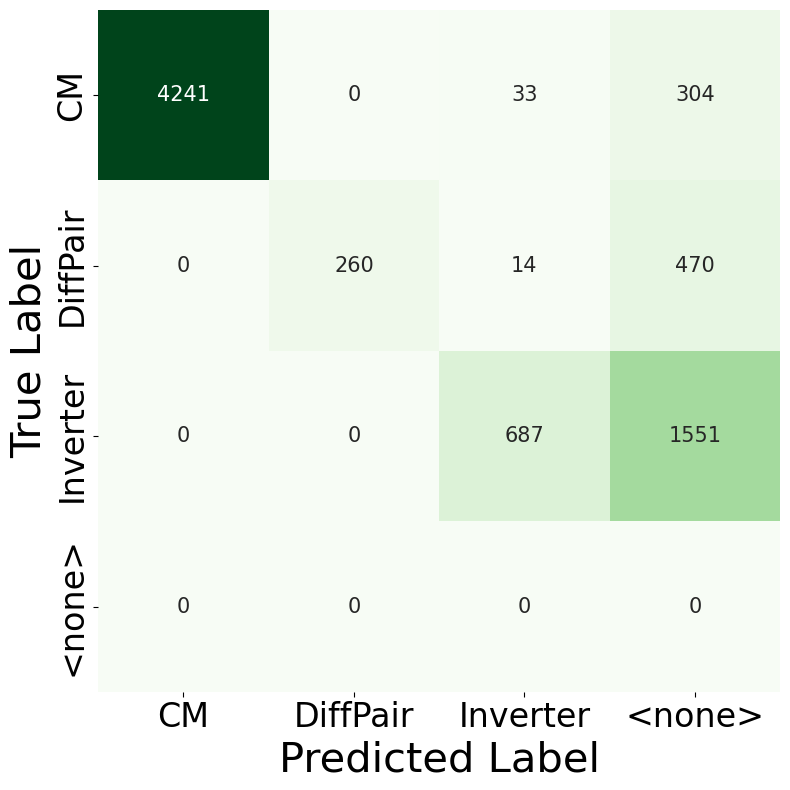

: 

In [ ]:
import sys
sys.path.append("../../") # go to parent dir
import os
os. chdir("/home/pham/code/asi-lm/")
print (os. getcwd())
import json
from calc1 import average_metrics
from examples.measure_fn2 import compute_cluster_metrics_v2 as stand_eval_fn
from calc1 import compute_cluster_metrics as strict_eval_fn


hl1_info, hl2_info, hl3_info = code_eval()
print ("Confusion Matrix HL1")
hl1_confusion_matrix = hl1_info["small"] + hl1_info["medium"] + hl1_info["large"]
hl1_confusion_matrix = hl1_confusion_matrix.astype(int)

print ("Confusion Matrix HL2")
#print (hl2_info)
hl2_confusion_matrix = hl2_info["small"] + hl2_info["medium"] + hl2_info["large"]
hl2_confusion_matrix = hl2_confusion_matrix.astype(int)
#print (hl2_confusion_matrix)

print ("Confusion Matrix HL3")
hl3_confusion_matrix = hl3_info["small"] + hl3_info["medium"] + hl3_info["large"]
hl3_confusion_matrix = hl3_confusion_matrix.astype(int)

def plot_confusion_matrix_custom(matrix, labels, title="Confusion Matrix", cmap="Greens"):
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"fontsize": 15},)
    plt.xlabel("Predicted Label", fontsize=30)
    plt.ylabel("True Label", fontsize=30)
    # plt.title(title, fontsize=20)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    plt.tight_layout()
    plt.savefig(title + ".pdf")
    plt.show()

plot_confusion_matrix_custom(hl2_confusion_matrix, ["CM", "DiffPair", "Inverter", "<none>"], title="Hierarchical Level 2")

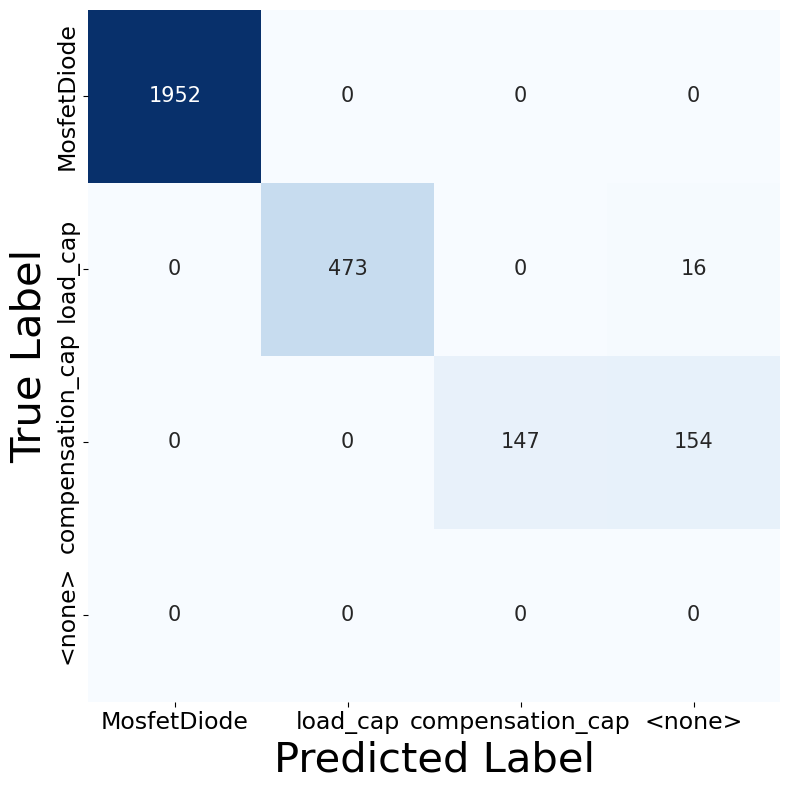

: 

In [ ]:
def plot_confusion_matrix(matrix, labels, title="Confusion Matrix",cmap='Oranges'):
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"fontsize": 15},)
    plt.xlabel("Predicted Label", fontsize=30)
    plt.ylabel("True Label", fontsize=30)
    # plt.title(title, fontsize=17)
    plt.xticks(
        # rotation=30,
        fontsize=17,
        # ha="right",
        # rotation_mode="anchor"
        ha='center'
    )
    plt.yticks(
        # rotation=30,
        fontsize=17,
        # ha="right",
        # rotation_mode="anchor"
        ha='right'
    )

    plt.tight_layout()
    plt.savefig(title + ".pdf")
    plt.show()
plot_confusion_matrix(hl1_confusion_matrix, ["MosfetDiode", "load_cap", "compensation_cap", "<none>"], title="Hierarchical Level 1", cmap="Blues")

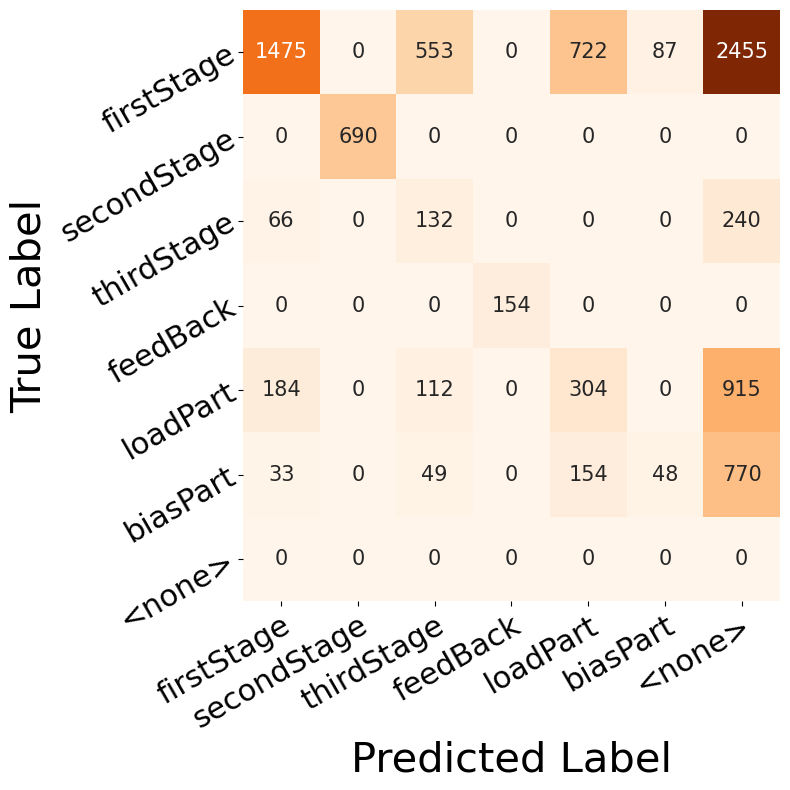

: 

In [ ]:
def plot_confusion_matrix(matrix, labels, title="Confusion Matrix", cmap='Oranges'):
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels, cbar=False, annot_kws={"fontsize": 15},)
    plt.xlabel("Predicted Label", fontsize=30)
    plt.ylabel("True Label", fontsize=30)
    # plt.title(title, fontsize=20)
    plt.xticks(
        rotation=30,
        fontsize=22,
        ha="right",
        rotation_mode="anchor"
    )
    plt.yticks(
        rotation=30,
        fontsize=22,
        ha="right",
        rotation_mode="anchor"
    )

    plt.tight_layout()
    plt.savefig(title + ".pdf")
    plt.show()
plot_confusion_matrix(hl3_confusion_matrix, ["firstStage", "secondStage", "thirdStage", "feedBack", "loadPart", "biasPart", "<none>"], title="Hierarchical Level 3")

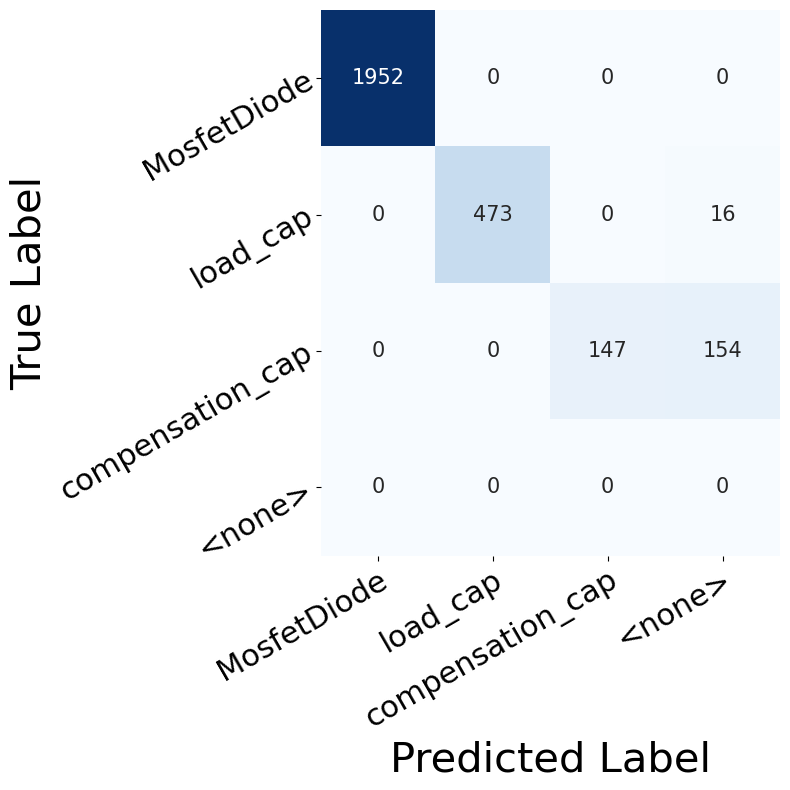

In [149]:
plot_confusion_matrix(hl1_confusion_matrix, ["MosfetDiode", "load_cap", "compensation_cap", "<none>"], title="Hierarchical Level 1",  cmap="Blues")